In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
from tools.audio import *
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [4]:
import random
files_path = r'C:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/audio/sounds'
files = librosa.util.find_files(files_path, ext=['wav'], recurse=True)
f = files[random.randint(0, len(files))]
f =  r'C:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/audio/sounds/3-253084-E-2.wav'
# Play the audio with sounddevice
import sounddevice as sd
# Load the audio file
audio, sr = read_audio(f)
spec = get_spectrogram(audio)
# Play the audio file
spec.shape

torch.Size([1, 1025, 251])

In [4]:
n_masks = 9
T = 200

In [5]:
spec_n_freq, spec_n_time = spec.shape[1], spec.shape[2]

In [6]:
masks = torch.zeros(n_masks, spec_n_freq, spec_n_time).bool()
t = np.random.randint(0, T, n_masks) # [0, T)
t0 = np.random.randint(0, spec_n_time - t, n_masks) # [0, tau - t)
for i in range(n_masks):
    masks[i, :, t0[i]:t0[i] + t[i]] = True

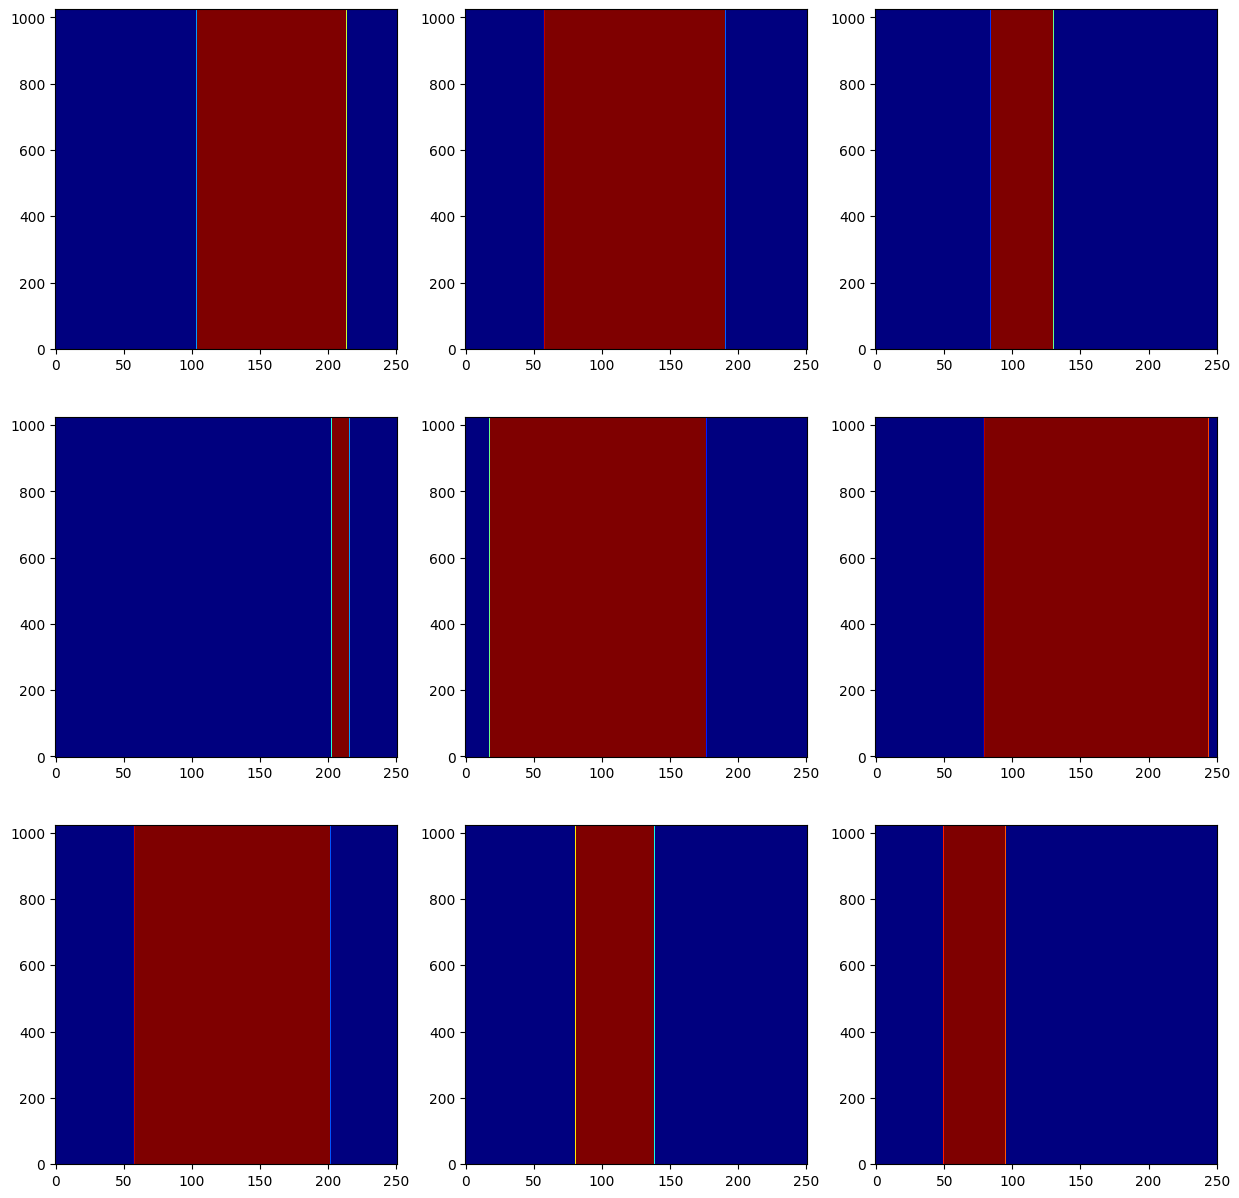

In [7]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(masks[i], origin='lower', cmap='jet', aspect='auto')
plt.show()

In [5]:
import matplotlib.pyplot as plt
# Apply the masks to the spectrogram
from tools.masking import create_freq_masks, create_time_masks, apply_masks
from tools.audio import get_spectrogram, read_audio, get_complex_spectrogram, inverse_complex_spectrogram

In [8]:
f = r'C:\Users\Diego\Documents\DTU\Fall2023\DL\Project\DL_RELAX\audio\sounds\1-19026-A-43.wav'
f = r'C:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/audio/sounds/3-253084-E-2.wav'
f = r'C:\Users\Diego\Documents\DTU\Fall2023\DL\Project\DL_RELAX\audio\sounds\5-221528-A-39.wav'
audio, sr = read_audio(f)
n_ftt = 2048
cpx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')

In [9]:
cpx_spec.shape

torch.Size([1, 1025, 251])

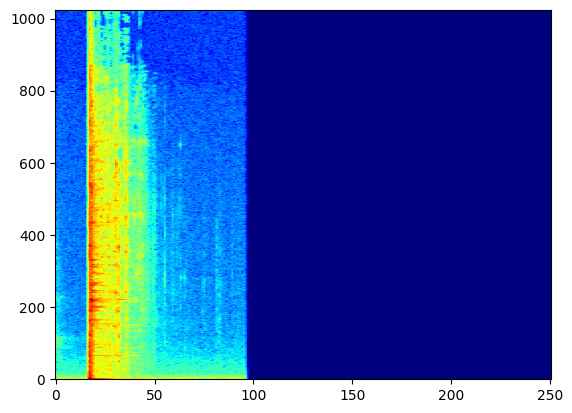

In [10]:
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')


In [11]:
T = 200
F = 200
n_masks = 500
n_ftt= 2048
time_masks = create_time_masks(cpx_spec.shape[1:3], T , n_masks)
freq_masks = create_freq_masks(cpx_spec.shape[1:3], F, n_masks)

In [13]:
masked_spec_time = apply_masks(cpx_spec, time_masks)
masked_spec_freq = apply_masks(cpx_spec, freq_masks)
masked_audios = inverse_complex_spectrogram(masked_spec_time, n_ftt=n_ftt)
print(masked_audios.shape, masked_audios.dtype)

torch.Size([500, 220500]) torch.float32


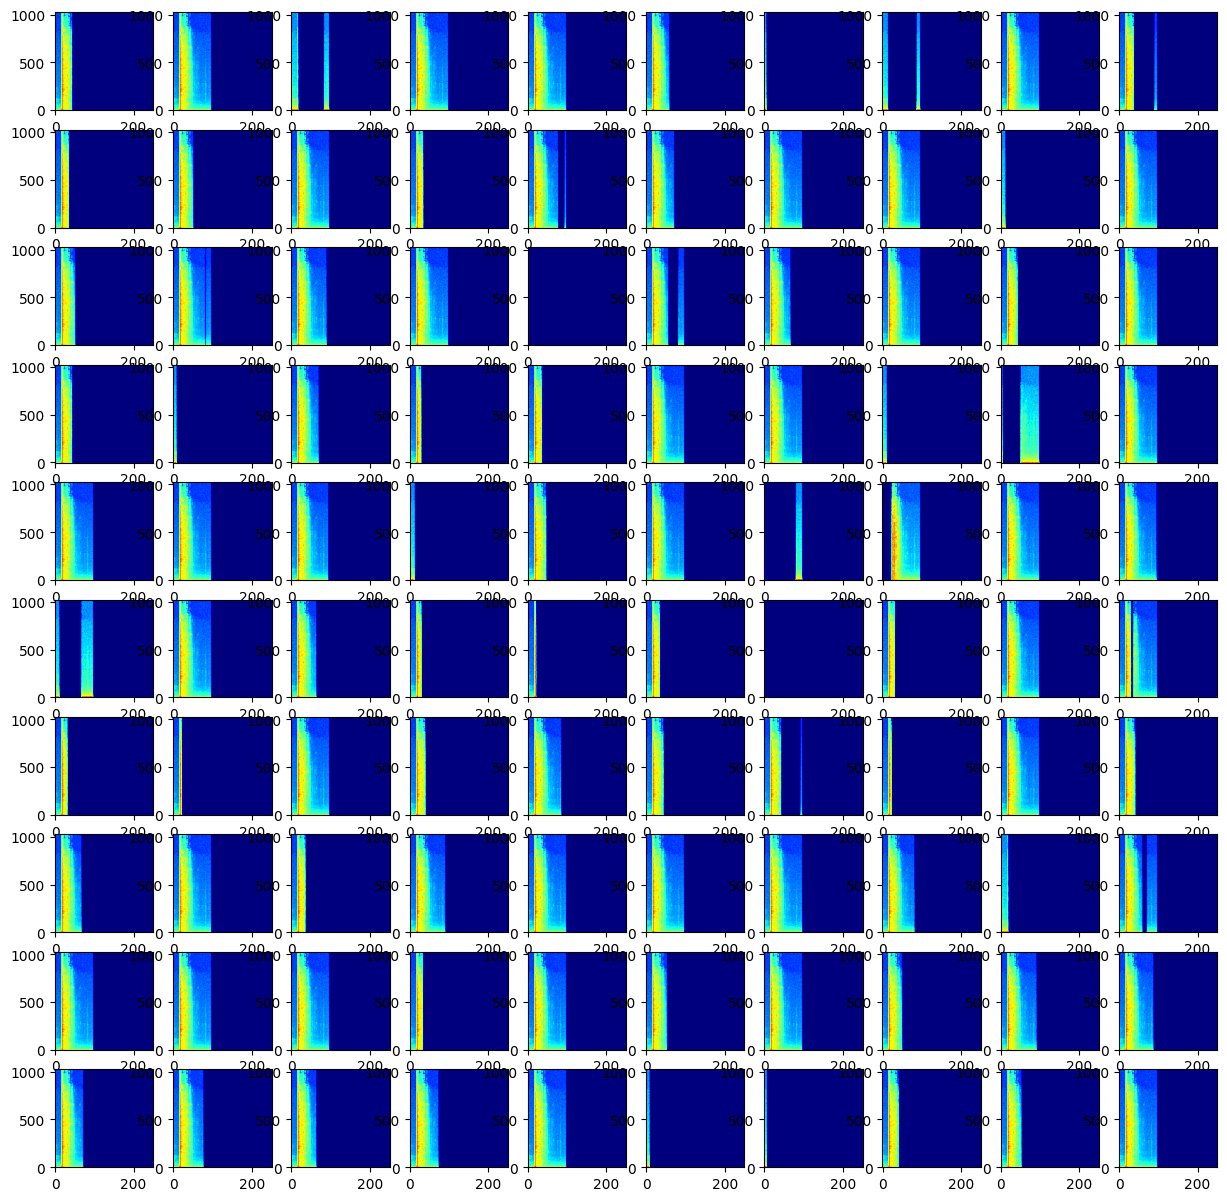

In [14]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(100):
    tmp_spec = get_spectrogram(masked_audios[i], n_ftt=n_ftt)
    tmp_spec_db = convert_to_db(tmp_spec)
    plt.subplot(10,10,i+1)
    plt.imshow(tmp_spec_db, origin='lower', cmap='jet', aspect='auto')
plt.show()

In [15]:
# Play masked audio
ix_audio = 3
play_audio(masked_audios[ix_audio], sr)

## Beats

In [17]:
from tools.audio import resample_audio
from prediction import load_beats_model

In [18]:
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios, sr, 16000)

In [20]:
import torch
masked_audio_inputs = torch.reshape(res_masked_audios, (n_masks, 1, res_masked_audios.shape[1]))

In [21]:
masked_audio_inputs.shape

torch.Size([500, 1, 80000])

In [22]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# Load BEATS model
model_path = 'audio/models/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

# Extract features of the original audio
h, _, _, h_prev  = beats_model.extract_features(res_audio)
h_star = h.expand(n_masks, -1)
h_star.shape, h.shape


(torch.Size([500, 527]), torch.Size([1, 527]))

In [23]:
from tqdm import tqdm

In [161]:
# Compute cosine similarity between original and masked features
import torch
from torch.nn.functional import cosine_similarity as cosine_sim
with torch.no_grad():
    W = torch.ones(tuple(time_masks.shape))
    R = torch.zeros(tuple(time_masks.shape))
    U = torch.zeros(tuple(time_masks.shape))
    for mask_idx, x_masked in tqdm(enumerate(masked_audio_inputs), total=n_masks):
        raw_mask = time_masks[mask_idx].float()
        W += raw_mask
        h_mask, _, _, _ = beats_model.extract_features(x_masked)
        s = cosine_sim(h, h_mask)
        R_prev = R
        R += raw_mask * (s - R) / W
        U += (s - R) * (s - R_prev) * raw_mask

100%|██████████| 500/500 [14:15<00:00,  1.71s/it]


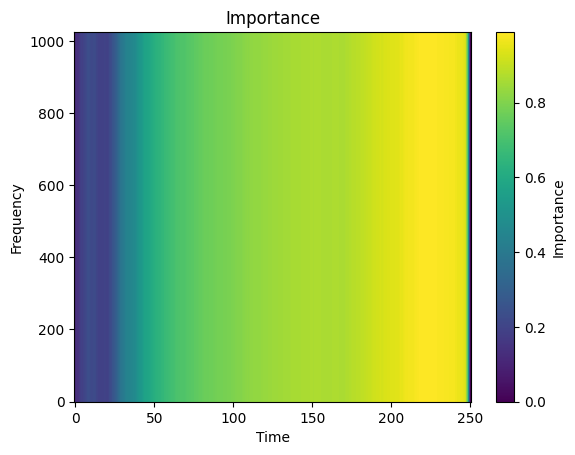

In [162]:
mean = torch.mean(R, dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Importance')
plt.title('Importance')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

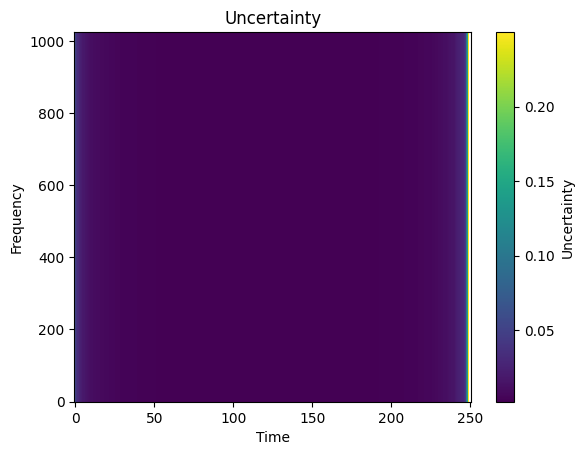

In [154]:
mean = torch.mean(U/(W-1), dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [169]:
# Compute cosine similarity between original and masked features
from torch.nn.functional import cosine_similarity as cosine_sim
# Extract features of the masked audios
_, _, x, m_logits = beats_model.extract_features(masked_audio_inputs[1])

# Compute cosine similarity
cos_sim = cosine_sim(h, m_logits)
print(cos_sim.shape, cos_sim.dtype)
# Display similarity histogram
plt.hist(cos_sim.detach().numpy(), bins=100)
plt.show()


RuntimeError: The size of tensor a (527) must match the size of tensor b (768) at non-singleton dimension 1

100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


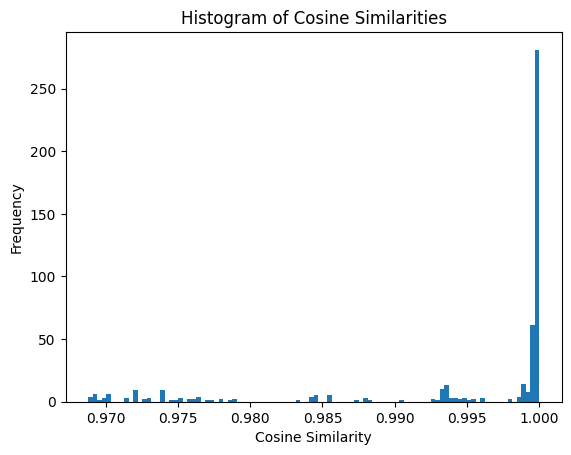

In [158]:
import matplotlib.pyplot as plt

cos_sim_list = []
for i in tqdm(range(n_masks), total=n_masks):
    _, _, x, m_logits = beats_model.extract_features(masked_audio_inputs[i])
    cos_sim = cosine_sim(h, x)
    cos_sim_list.append(cos_sim.item())

plt.hist(cos_sim_list, bins=100)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()

## Manhattan distance

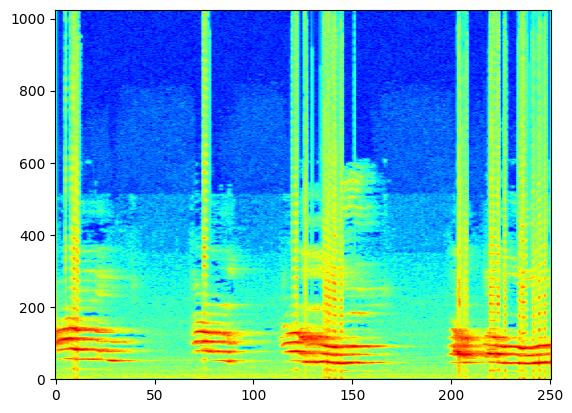

In [91]:
import glob
import sounddevice as sd

# FILEPATH: /c:/Users/Diego/Documents/DTU/Fall2023/DL/Project/DL_RELAX/time_masking.ipynb
files = glob.glob('audio/sounds/*.wav')
f = random.choice(files)

audio, sr = read_audio(f)
n_ftt = 2048
cpx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
spec = get_spectrogram(audio, n_ftt=n_ftt)
spec = convert_to_db(spec)
plt.imshow(spec[0,:,:], origin='lower', cmap='jet', aspect='auto')


# Play the audio
play_audio(audio, sr)


In [92]:
cat_sound = 'audio/sounds\\5-172299-A-5.wav'

'audio/sounds\\5-172299-A-5.wav'

In [93]:
from tqdm import tqdm

In [112]:
T = 200
F = 200
n_masks = 1000
n_ftt= 2048
time_masks = create_time_masks(cpx_spec.shape[1:3], T , n_masks)
freq_masks = create_freq_masks(cpx_spec.shape[1:3], F, n_masks)

In [113]:
masked_spec_time = apply_masks(cpx_spec, time_masks)
masked_spec_freq = apply_masks(cpx_spec, freq_masks)
masked_audios = inverse_complex_spectrogram(masked_spec_time, n_ftt=n_ftt)
print(masked_audios.shape, masked_audios.dtype)

torch.Size([1000, 220500]) torch.float32


In [114]:
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios, sr, 16000)

In [115]:
import torch
masked_audio_inputs = torch.reshape(res_masked_audios, (n_masks, 1, res_masked_audios.shape[1]))

In [116]:
# Load BEATS model
model_path = 'audio/models/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

# Extract features of the original audio
h_probs, _, h_logits, _  = beats_model.extract_features(res_audio)
h_star_probs = h_probs.expand(n_masks, -1)
h_star_logits = h_logits.expand(n_masks, -1)

with torch.no_grad():
    # Initialize R, U and W for both h_probs and h_logits
    R_probs = torch.zeros(tuple(time_masks.shape))
    U_probs = torch.zeros(tuple(time_masks.shape))
    R_logits = torch.zeros(tuple(time_masks.shape))
    U_logits = torch.zeros(tuple(time_masks.shape))

    W_logits = torch.ones(tuple(time_masks.shape))
    W_probs = torch.ones(tuple(time_masks.shape))

    for mask_idx, x_masked in tqdm(enumerate(masked_audio_inputs), total=n_masks):
        raw_mask = time_masks[mask_idx].float()
        W_logits += raw_mask
        W_probs += raw_mask
        h_mask_probs, _, h_mask_logits, _ = beats_model.extract_features(x_masked)
        s_probs = torch.dist(h_probs, h_mask_probs, p=1)
        s_logits = torch.dist(h_logits, h_mask_logits, p=1)
        R_probs_prev = R_probs
        R_probs += raw_mask * (s_probs - R_probs) / W_probs
        U_probs += (s_probs - R_probs) * (s_probs - R_probs_prev) * raw_mask

        R_logits_prev = R_logits
        R_logits += raw_mask * (s_logits - R_logits) / W_logits
        U_logits += (s_logits - R_logits) * (s_logits - R_logits_prev) * raw_mask

 25%|██▌       | 253/1000 [28:26<1:38:45,  7.93s/it]

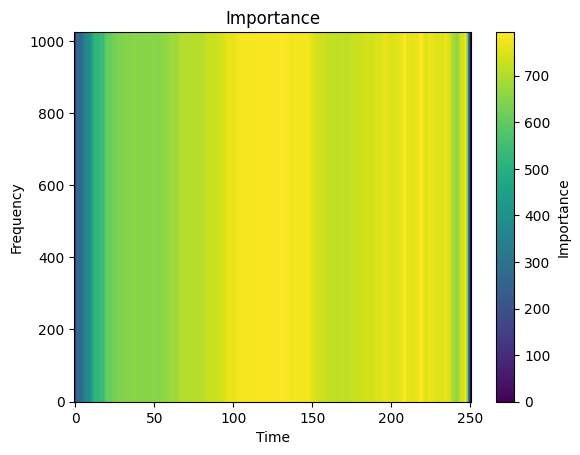

In [ ]:
mean = torch.mean(R_logits, dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Importance')
plt.title('Importance')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

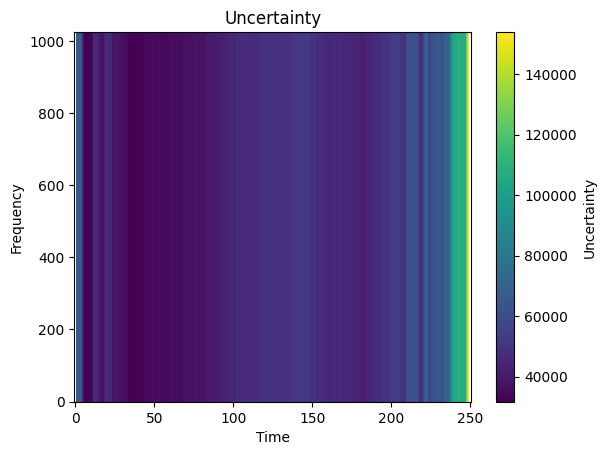

In [109]:
mean = torch.mean(U_logits/(W_logits-1), dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [110]:
h_logits_star = h_logits.expand(n_masks, -1)
h_logits_star.shape, h_logits.shape

(torch.Size([100, 527]), torch.Size([1, 527]))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Text(0.5, 1.0, 'Histogram of Manhattan Distances')

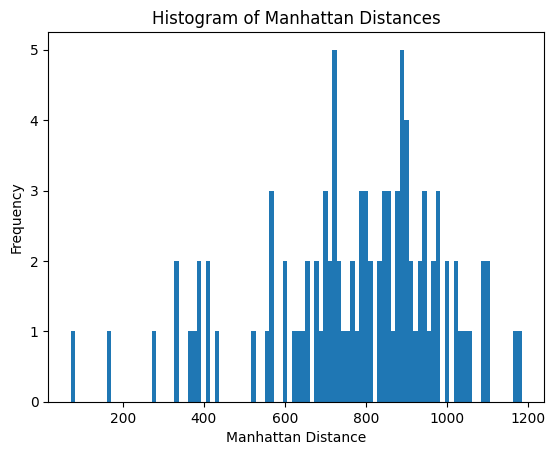

In [111]:
import numpy as np
import matplotlib.pyplot as plt

manhattan_dist_list = np.zeros(n_masks)
for i in tqdm(range(n_masks), total=n_masks):
    _, _, masked_logits, _ = beats_model.extract_features(masked_audio_inputs[i])
    manhattan_dist = torch.dist(h_logits, masked_logits, p=1)
    manhattan_dist_list[i] = manhattan_dist.item()

plt.hist(manhattan_dist_list, bins=100)
plt.xlabel('Manhattan Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Manhattan Distances')
